In [1]:
# Dependencies
import os
import json
from pprint import pprint
from geojson import Feature, Point, FeatureCollection

import pandas as pd
import numpy as np
import datetime as dt
import calendar
from matplotlib import pyplot as plt

In [2]:
# Import the ridership CSV file.
df = pd.read_csv(os.path.join('data', '2022', 'bst_ridership.csv'))
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620469 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Trip  Duration      4620469 non-null  int64  
 1   Start Station Id    4620469 non-null  int64  
 2   Start Time          4620469 non-null  object 
 3   Start Station Name  4437003 non-null  object 
 4   End Station Id      4619190 non-null  float64
 5   End Time            4620469 non-null  object 
 6   End Station Name    4435503 non-null  object 
 7   Bike Id             4620469 non-null  int64  
 8   User Type           4620469 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 317.3+ MB


## Stage 1: Data Type Conversions

In [3]:
df_1 = df.copy()

In [4]:
# Convert `Start Time` and `End Time` to datetime objects for easier downstream temporal manipulation.
df_1['Start Time'] = pd.to_datetime(df_1['Start Time'])
df_1['End Time'] = pd.to_datetime(df_1['End Time'])

In [5]:
# `End Station Id` should be of int64 type like `Start Station Id` but it's of float64 type due to the presence of NaNs when 
# the CSV file was read.
df_1['End Station Id'] = df_1['End Station Id'].astype('Int64')

In [6]:
# Reorder the columns.
df_1 = df_1.iloc[:, [2,5,0,1,3,4,6,7,8]]

In [7]:
df_1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620469 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Start Time          4620469 non-null  datetime64[ns]
 1   End Time            4620469 non-null  datetime64[ns]
 2   Trip  Duration      4620469 non-null  int64         
 3   Start Station Id    4620469 non-null  int64         
 4   Start Station Name  4437003 non-null  object        
 5   End Station Id      4619190 non-null  Int64         
 6   End Station Name    4435503 non-null  object        
 7   Bike Id             4620469 non-null  int64         
 8   User Type           4620469 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(3)
memory usage: 321.7+ MB


In [8]:
print('Number of bikes in 2022: ', df_1['Bike Id'].nunique())
print('Number of bike stations in 2022: ', df_1['Start Station Id'].nunique())

Number of bikes in 2022:  6830
Number of bike stations in 2022:  682


## Stage 2: Outliers in Trip Duration
We need to eliminate obvious outliers for `Trip Duration`.

In [9]:
df_2 = df_1.copy()

# Remove the substring `Member` in each record of `User Type`: `Annual Member` to `Annual` and `Casual Member` to `Casual`.
# Replace `Annual` with `Member` for clearer distinction between the two types of riders, causual riders and membership riders.
df_2['User Type'] = df_2['User Type'].str.replace(' Member', '')
df_2['User Type'] = df_2['User Type'].str.replace('Annual', 'Member')

# Rename `Trip Duration` to `Duration`.
df_2.rename(columns={'Trip  Duration': 'Duration'}, inplace=True)

# Limit the trip length to le 1 day but ge 1 min.
print(f"{(df_2['Duration']<60).sum()} trips did not last more than 1 min.\n"
      f"{(df_2['Duration']>(60*60*24)).sum()} trips lasted more than 1 day.")
df_2 = df_2[(df_2['Duration']>=60) & (df_2['Duration']<=(60*60*24))]

10155 trips did not last more than 1 min.
679 trips lasted more than 1 day.


In [10]:
# # Statistical Approach
# # Option 1: Determine the outliers in terms of trip duration.
# q1 = df_2['Duration'].quantile(0.25)
# q3 = df_2['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')

# outliers = df_2['Duration']>(q3+1.5*iqr)
# # Note that q1-1.5*iqr is negative, so it's not included in the computation.
# df_2[~outliers] # Can assign to df_2 if this approach is used.

# # The way the distribution for casual riders trails off looks like information lost rather than outlier removal.
# # Option 2: Determine the outliers in terms of trip duration for each `User Type`.
# df_2[~outliers][df_2[~outliers]['User Type'] == 'Casual']['Duration'].hist(bins=30)
# plt.xlim([0, q3+1.5*iqr])

# # Compute the outliers for members.
# df_2_annual = df_2[df_2['User Type'] == 'Member']
# q1 = df_2_annual['Duration'].quantile(0.25)
# q3 = df_2_annual['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'Members: q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')
# df_2_annual = df_2_annual[~(df_2_annual['Duration']>(q3+1.5*iqr))]

# # Compute the outliers for casuals.
# df_2_casual = df_2[df_2['User Type'] == 'Casual']
# q1 = df_2_casual['Duration'].quantile(0.25)
# q3 = df_2_casual['Duration'].quantile(0.75)
# iqr = q3 - q1
# print(f'Casuals: q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}')
# df_2_casual = df_2_casual[~(df_2_casual['Duration']>(q3+1.5*iqr))]

# pd.concat([df_2_annual, df_2_casual]) # Can assign to df_2 if this approach is used.

In [11]:
df_2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609635 entries, 0 to 4620468
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Start Time          4609635 non-null  datetime64[ns]
 1   End Time            4609635 non-null  datetime64[ns]
 2   Duration            4609635 non-null  int64         
 3   Start Station Id    4609635 non-null  int64         
 4   Start Station Name  4426570 non-null  object        
 5   End Station Id      4609602 non-null  Int64         
 6   End Station Name    4426353 non-null  object        
 7   Bike Id             4609635 non-null  int64         
 8   User Type           4609635 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(3)
memory usage: 356.1+ MB


### `User Type`

In [12]:
# Make a copy of the current DataFrame to prepare for `User Type` summaries.
trips = df_2.copy()

# Insert new columns `Date`, `Month`, `Day`, and `Hour` based on the start time of each recorded trip.
ts = trips['Start Time']
trips = trips.assign(Date=ts.dt.date, 
                     Month=ts.dt.month, # ts.dt.strftime('%b')
                     Day=ts.dt.weekday, # ts.dt.strftime('%a')
                     Hour=ts.dt.hour)
trips.rename(columns={'Day': 'Day of Week'}, inplace=True)

# Drop columns that are no longer relevant.
trips.drop(columns=['Start Time', 'End Time', 
                    'Start Station Id', 'Start Station Name',
                    'End Station Id', 'End Station Name', 'Bike Id'], inplace=True)

# Reorder the columns.
trips = trips.iloc[:, [2,3,4,5,0,1]]
trips.head()

,Date,Month,Day of Week,Hour,Duration,User Type
0,2022-01-01,1,5,0,4335,Casual
1,2022-01-01,1,5,0,126,Member
2,2022-01-01,1,5,0,942,Member
3,2022-01-01,1,5,0,4256,Casual
4,2022-01-01,1,5,0,4353,Casual


In [13]:
# Create a table that summarizes the trip count by year, month, day of the week, and hour.
# by year
trip_count_by_year = df_2['User Type'].value_counts().sort_index().to_frame(name='Yearly')
# by month
trip_count_by_month = trips.groupby(['Month', 'User Type'])['User Type'].count().unstack().T
trip_count_by_month.columns = trip_count_by_month.columns.map(lambda x:calendar.month_abbr[x])
# by day of the week
trip_count_by_dow = trips.groupby(['Day of Week', 'User Type'])['User Type'].count().unstack().T
trip_count_by_dow.columns = trip_count_by_dow.columns.map(lambda x:calendar.day_abbr[x])
# by hour
trip_count_by_hour = trips.groupby(['Hour', 'User Type'])['User Type'].count().unstack().T
# Concatenate them and export the table to a JSON file.
trip_count = pd.concat([trip_count_by_year, 
                        trip_count_by_month, 
                        trip_count_by_dow,
                        trip_count_by_hour], axis=1)

In [14]:
trip_count

,Yearly,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,14,15,16,17,18,19,20,21,22,23
Casual,2872858,16169,20397,58551,128209,344635,470732,366120,412283,383239,...,181210,199630,232649,284724,265619,217499,167354,129061,101521,80800
Member,1736777,40218,46436,93130,117319,159406,133901,312619,291325,217861,...,95225,107367,135103,174425,154736,119074,88888,68959,53870,41297


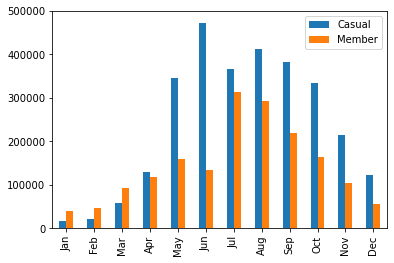

In [15]:
trip_count.T.iloc[1:13].plot.bar()
plt.ylim([0, 500000]);

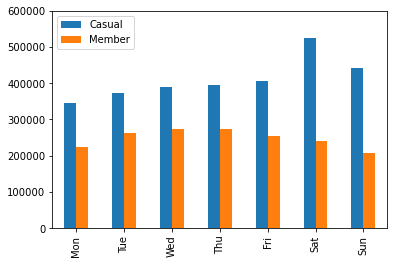

In [16]:
trip_count.T.iloc[13:20].plot.bar()
plt.ylim([0, 600000]);

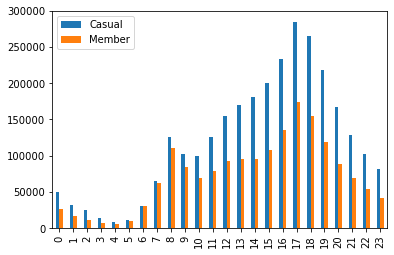

In [17]:
trip_count.T.iloc[20:44].plot.bar()
plt.ylim([0, 300000]);

In [18]:
# Create a table that summarizes the average trip duration by year, month, day of the week, and hour.
# By year
avg_dur_by_year = trips.groupby('User Type')['Duration'].mean().sort_index().to_frame(name='Yearly')
# By month
avg_dur_by_month = trips.groupby(['Month', 'User Type'])['Duration'].mean().unstack().T
avg_dur_by_month.columns = avg_dur_by_month.columns.map(lambda x:calendar.month_abbr[x])
# By day of the week
avg_dur_by_dow = trips.groupby(['Day of Week', 'User Type'])['Duration'].mean().unstack().T
avg_dur_by_dow.columns = avg_dur_by_dow.columns.map(lambda x:calendar.day_abbr[x])
# By hour
avg_dur_by_hour = trips.groupby(['Hour', 'User Type'])['Duration'].mean().unstack().T
# Concatenate them and export the table to a JSON file
avg_dur = pd.concat([avg_dur_by_year, 
                     avg_dur_by_month, 
                     avg_dur_by_dow, 
                     avg_dur_by_hour], axis=1)

In [19]:
avg_dur

,Yearly,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,14,15,16,17,18,19,20,21,22,23
User Type,,,,,,,,,,,,,,,,,,,,,
Casual,1064.046363,972.005566,888.381625,989.857953,1098.639370,1150.820094,1068.263815,1252.476874,1161.170968,1041.672666,...,1137.186574,1131.600957,1096.364695,1065.218675,1085.717599,1112.829093,1107.406964,1084.487180,1088.510023,1117.212277
Member,700.816806,668.173007,641.050500,637.685687,663.648378,723.127843,714.681907,736.987115,727.691125,715.004126,...,701.946621,705.233088,714.114246,728.587485,731.756049,730.615819,730.155083,732.391537,736.786987,719.904327


In [20]:
# Calculate the total trip duration for each User Type.
trips.groupby('User Type')['Duration'].sum().sort_index()

User Type
Casual    3056854106
Member    1217162510
Name: Duration, dtype: int64

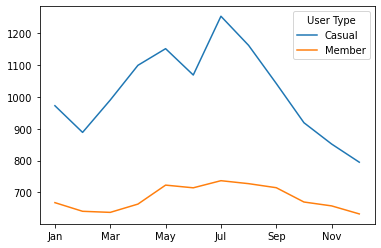

In [21]:
avg_dur.T.iloc[1:13].plot();

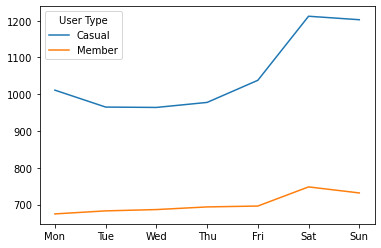

In [22]:
avg_dur.T.iloc[13:20].plot();

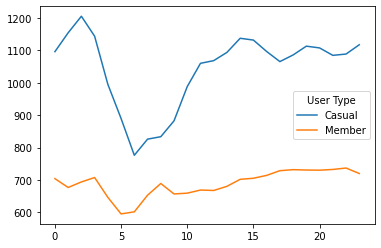

In [23]:
avg_dur.T.iloc[20:44].plot();

### `Bike Id`
This aspect of the dataset will be excluded from the current investigation but warrants future investigation into how the bikes are maintained and used within the system. Parameters of interest would include trip duration, idle duration, percentage of trips being quick transits (note the conservative approach below), and how widely and quickly a bike shared travels across the system (number of unique pickup stations versus total number of trips).

Also, one feature to showcase could be to select a bike Id from the database and show all the logged activites on an open map. However, consider the size of the database: 6800 bikes and 4 million records will take declustering to present on Leaflet.

In [24]:
# def idle_time(bike):
#     '''
#     This function calculates the idle time for each bike, which is the period of time between its last dropoff and next pickup.
#     This in turn allows for the estimation of how many trips taken are quick transits.
#     '''
#     if len(bike) == 1:
#         # If there is only one record of the bike in use, the idle time is based on the difference between the drop-off time
#         # and the end of the year. Considering that all 3 bikes that saw only one trip in 2022 were used in December, this is
#         # reasonble.
#         # Bikes that saw only 1 trip had Id's 1986, 1253, and 513.
#         idle = dt.datetime(2023, 1, 1, 0, 0, 0) - bike['End Time']
#     else:
#         idle = (bike['Start Time'] - bike['End Time'].shift()).iloc[1:]
#     # Negative values that appear as a result of Daylight Saving on Nov 6, 2022 need to be adjusted. There are a total of 16
#     # records that are affected.
#     idle[idle.dt.total_seconds()<0] += dt.timedelta(seconds=3600)
#     return idle.dt.total_seconds()

In [25]:
# def bike_agg(bike):
#     idle_periods = idle_time(bike)
#     features ={
#         'First Pickup': bike['Start Time'].min(),
#         'Last Dropoff': bike['End Time'].max(),
#         'Service Span': bike['End Time'].max() - bike['Start Time'].min(),
#         'Total Number of Trips': bike['Duration'].count(),
#         'Total Trip Duration': bike['Duration'].sum(),
#         'Longest Trip Duration': bike['Duration'].max(),
#         'Shortest Trip Duration': bike['Duration'].min(),
#         'Total Idle Period': idle_periods.sum(),
#         'Longest Idle Period': idle_periods.max(),
#         'Shortest Idle Period': idle_periods.min()
#     }
#     return pd.Series(features, index=features.keys())

In [26]:
# # Apply the custom aggregation function to `Bike Id`.
# bikes = df_2.groupby('Bike Id').apply(bike_agg)

## Stage 3: Station Ids

In [27]:
# Import the latest station info and create a DataFrame for it.
station_info = pd.read_json(os.path.join('data', 'station_info.json'))
stations_todate = station_info.loc[:, ['station_id', 'name', 'lat', 'lon']]
stations_todate.rename(columns={'station_id':'Station Id', 'name':'Name', 'lat':'Lat', 'lon':'Lon'}, inplace=True)
stations_todate.set_index('Station Id', inplace=True)
stations_todate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 7000 to 7772
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    655 non-null    object 
 1   Lat     655 non-null    float64
 2   Lon     655 non-null    float64
dtypes: float64(2), object(1)
memory usage: 20.5+ KB


In [28]:
df_3 = df_2.copy()
df_3.drop(columns=['Start Station Name', 'End Station Name'], inplace=True)
df_3.dropna(inplace=True) # Only 33 records due to NaNs in `End Station Id`
df_3.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4609602 entries, 0 to 4620468
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Start Time        4609602 non-null  datetime64[ns]
 1   End Time          4609602 non-null  datetime64[ns]
 2   Duration          4609602 non-null  int64         
 3   Start Station Id  4609602 non-null  int64         
 4   End Station Id    4609602 non-null  Int64         
 5   Bike Id           4609602 non-null  int64         
 6   User Type         4609602 non-null  object        
dtypes: Int64(1), datetime64[ns](2), int64(3), object(1)
memory usage: 285.7+ MB


In [29]:
# Compute how many stations are missing coord info if we want to map the results downstream through Leaflet
station_id = df_3['Start Station Id'].unique()
missing_station_id = []
for i in station_id:
    if i not in stations_todate.index:
        missing_station_id.append(i)
len(missing_station_id)

38

In [30]:
# Create a custom aggregation function.
def station_agg(grp):
    features ={
        'Yearly Casual Trips': grp[grp['User Type'] == 'Casual']['Duration'].count(),
        'Yearly Total Trips': grp['Duration'].count(),
        'June Casual Trips': grp[(grp['Start Time'].dt.month == 6) & (grp['User Type'] == 'Casual')]['Duration'].count(),
        'June Casual Total Duration': grp[(grp['Start Time'].dt.month == 6) & (grp['User Type'] == 'Casual')]['Duration'].sum()
    }
    return pd.Series(features)

stations = df_3.groupby('Start Station Id').apply(station_agg).rename_axis('Station Id')

stations.insert(0, 'Yearly Casual Trip Percentage', stations['Yearly Casual Trips']*100/stations['Yearly Total Trips'])
stations['June Casual Trip Average Duration'] = stations['June Casual Total Duration']/stations['June Casual Trips']
stations['June Casual Trip Average Duration'] = stations['June Casual Trip Average Duration'].fillna(0)

stations.drop(columns=['Yearly Casual Trips', 'June Casual Total Duration'], inplace=True)
stations_summary = stations_todate.merge(stations, left_index=True, right_index=True)

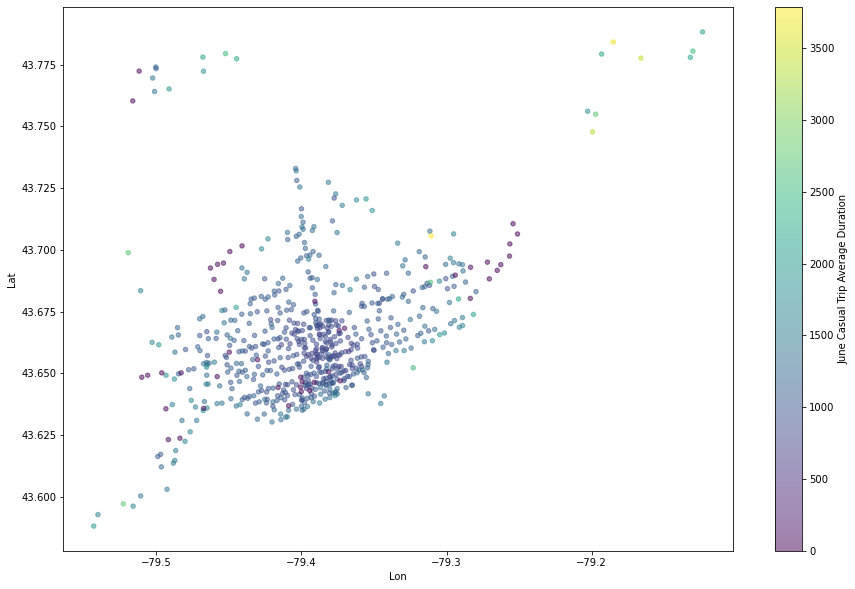

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
stations_summary.plot.scatter(
    x='Lon', y='Lat',
    c='June Casual Trip Average Duration', 
    colormap='viridis', # colormap=plt.cm.get_cmap('viridis').reversed()
    alpha=0.5, ax=ax);

### Flowmap
Prepare a custom geoJSON file that aims to show traffic to the busiest end station during morning peak hour.

In [32]:
# Prepare the Dataframe to make sure that all station coordinates are available based on info to date.
df_3 = df_3[df_3['Start Station Id'].isin(stations_todate.index)]
df_3 = df_3[df_3['End Station Id'].isin(stations_todate.index)]

In [33]:
# Station with the id 7015 was the busiest for both casual and membership riders.
df_3[(df_3['Start Time'].dt.hour == 8) & (df_3['User Type'] == 'Member')]['End Station Id'].value_counts()

7015    3646
7047    1724
7033    1632
7502    1309
7076    1151
        ... 
7590       1
7582       1
7631       1
7733       1
7567       1
Name: End Station Id, Length: 607, dtype: Int64

In [34]:
df_3[(df_3['Start Time'].dt.hour == 8) & (df_3['User Type'] == 'Casual')]['End Station Id'].value_counts()

7015    3697
7047    1823
7033    1784
7502    1567
7076    1476
        ... 
7694       1
7602       1
7733       1
7760       1
7631       1
Name: End Station Id, Length: 624, dtype: Int64

In [35]:
# This function outputs geoJOSN file in a format required of flowmap visualization.
def flowmapJSON_manytoone(end_station, stations, end_id=None):
    if end_id is None:
        end_id = end_station.name
    start_ids = end_station['Start Station Id'].unique()
    feature_list = []
    for start_id in start_ids:
        if start_id in stations.index:
            feature = Feature(geometry=Point((stations.loc[end_id]['Lon'], stations.loc[end_id]['Lat'])))
            feature.properties = {
                "origin_id": int(start_id),
                "origin_lon": stations.loc[start_id]['Lon'],
                "origin_lat": stations.loc[start_id]['Lat'],
                "destination_id": int(end_id),
                "destination_lon": stations.loc[end_id]['Lon'],
                "destination_lat": stations.loc[end_id]['Lat']
            }
            feature_list.append(feature)
    return FeatureCollection(feature_list)   

In [36]:
# # Option 1 for flowmapJSON_manytoone(): operate on all stations.
# df_3.groupby('End Station Id').apply(
#     flowmapJSON_manytoone, stations=stations_todate) #.to_json(os.path.join('data', '2022', 'stations_flowmap.json'), orient='index')

# Option 2 for flowmapJSON_manytoone(): operate on a single end station.
criteria = (df_3['End Station Id'] == 7015) & (df_3['Start Time'].dt.hour == 8) & (df_3['User Type'] == 'Casual')
with open(os.path.join('data', '2022', 'flowmap.json'), 'w') as fp:
    json.dump([flowmapJSON_manytoone(df_3[criteria], stations_todate, 7015)], fp)

In [37]:
# Export JSON files.
# trip_count.to_json(os.path.join('data', '2022', 'trip_count_summary.json'), orient='index')
# avg_dur.to_json(os.path.join('data', '2022', 'avg_dur_summary.json'), orient='index')
# stations_summary.to_json(os.path.join('data', '2022', 'stations_summary.json'), orient='index')